# 1. Исследовательский анализ данных

In [26]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [28]:
print(labels.shape)

(7591, 2)


In [29]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [30]:
labels.median()

real_age    29.0
dtype: float64

In [31]:
labels['real_age'].quantile(.995)

88.05000000000018

Text(0.5, 1.0, 'Распределения возраста')

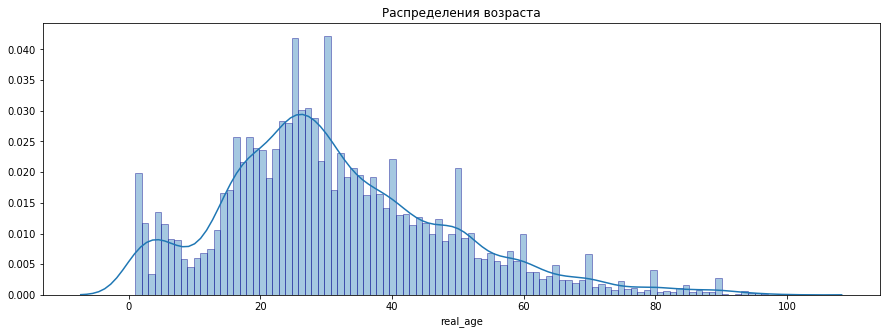

In [32]:
fig = plt.figure(figsize=(15,5))
sns.distplot(labels.real_age, kde = True,  bins=labels.real_age.max(),hist_kws={'edgecolor':'darkblue'}).set_title('Распределения возраста')

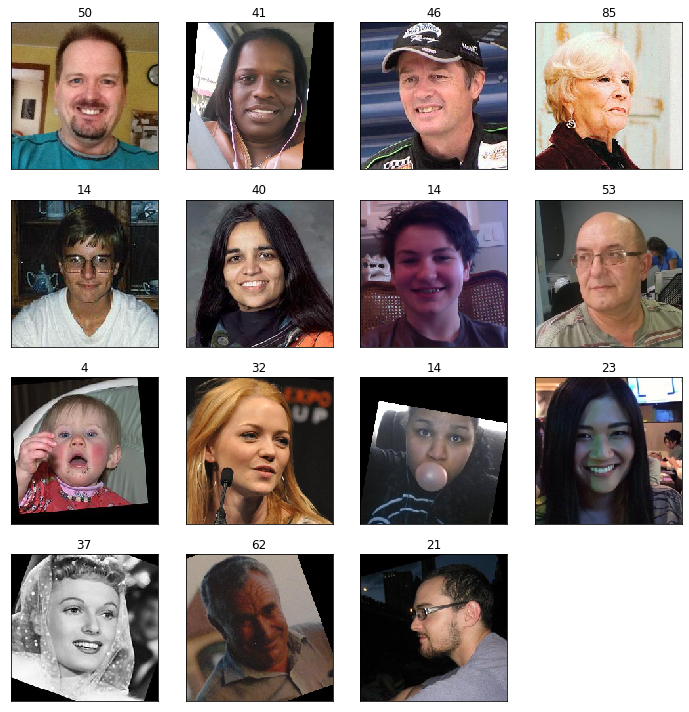

In [33]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(target[i])
    plt.tight_layout()

### Выводы:

    7591 изображений.

    Возраст распределен нормально со скошенностью вправо.
    Много фотографий детей до 10 лет.
    Больше всего фотографий людей возраста около 25-30 лет. 
    Чаще всего встречается возраст от 20 лет до 41 года.
    Мало фотографий людей от 60 лет, поэтому модель может плохо определять старший возраст.
    Аномальный возраст - 88 лет и более. 


    Есть цветные и черно-белые фотографии. 
    Фотографии людей представлены в разных ракурсах: анфас, в полоборота, в профиль.
    Есть фотографии, которые имеют наклон или смещение.

    Будем использовать горизонтальное отражение фотографии для аугментации.

# 2. Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```
2020-11-05 18:48:08.713619: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6

2020-11-05 18:48:08.715447: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6

Using TensorFlow backend.

Found 5694 validated image filenames.

Found 1897 validated image filenames.

2020-11-05 18:48:09.752313: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1

2020-11-05 18:48:10.411077: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 

pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0

coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s

2020-11-05 18:48:10.411159: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

2020-11-05 18:48:10.411196: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2020-11-05 18:48:10.413457: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10

2020-11-05 18:48:10.413839: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10

2020-11-05 18:48:10.416315: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10

2020-11-05 18:48:10.417637: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10

2020-11-05 18:48:10.417703: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

2020-11-05 18:48:10.421564: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0

2020-11-05 18:48:10.421936: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA

2020-11-05 18:48:10.429577: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999990000 Hz

2020-11-05 18:48:10.430200: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5ada070 initialized for platform Host (this does not guarantee that XLA will be used). Devices:

2020-11-05 18:48:10.430228: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version

2020-11-05 18:48:10.562283: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5b60090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:

2020-11-05 18:48:10.562329: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0

2020-11-05 18:48:10.564393: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 

pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0

coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s

2020-11-05 18:48:10.564463: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

2020-11-05 18:48:10.564476: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2020-11-05 18:48:10.564499: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10

2020-11-05 18:48:10.564513: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10

2020-11-05 18:48:10.564526: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10

2020-11-05 18:48:10.564538: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10

2020-11-05 18:48:10.564547: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

2020-11-05 18:48:10.568339: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0

2020-11-05 18:48:10.568407: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

2020-11-05 18:48:10.901956: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:

2020-11-05 18:48:10.902042: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 

2020-11-05 18:48:10.902052: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 

2020-11-05 18:48:10.905916: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

Train for 356 steps, validate for 119 steps

Epoch 1/20

2020-11-05 18:48:23.780013: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2020-11-05 18:48:24.112826: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

356/356 - 53s - loss: 226.7899 - mae: 11.2736 - val_loss: 329.2061 - val_mae: 13.4553

Epoch 2/20

356/356 - 44s - loss: 138.1975 - mae: 8.9677 - val_loss: 253.0965 - val_mae: 11.9558

Epoch 3/20

356/356 - 43s - loss: 112.5257 - mae: 8.0509 - val_loss: 105.0360 - val_mae: 7.7737

Epoch 4/20

356/356 - 43s - loss: 92.4796 - mae: 7.3359 - val_loss: 129.9136 - val_mae: 8.5401

Epoch 5/20

356/356 - 43s - loss: 78.8094 - mae: 6.8663 - val_loss: 121.4705 - val_mae: 8.5312

Epoch 6/20

356/356 - 43s - loss: 70.9001 - mae: 6.4596 - val_loss: 104.5691 - val_mae: 7.9443

Epoch 7/20

356/356 - 43s - loss: 57.8148 - mae: 5.8535 - val_loss: 133.0430 - val_mae: 8.5706

Epoch 8/20

356/356 - 44s - loss: 47.9268 - mae: 5.3348 - val_loss: 100.4553 - val_mae: 7.5851

Epoch 9/20

356/356 - 43s - loss: 47.1156 - mae: 5.2717 - val_loss: 91.4975 - val_mae: 7.1634

Epoch 10/20

356/356 - 43s - loss: 37.0309 - mae: 4.6650 - val_loss: 129.3390 - val_mae: 8.5660

Epoch 11/20

356/356 - 43s - loss: 36.7857 - mae: 4.6738 - val_loss: 92.6575 - val_mae: 7.3108

Epoch 12/20

356/356 - 43s - loss: 31.0256 - mae: 4.2903 - val_loss: 101.6054 - val_mae: 7.7943

Epoch 13/20

356/356 - 43s - loss: 27.7932 - mae: 4.0278 - val_loss: 102.0766 - val_mae: 7.5442

Epoch 14/20

356/356 - 43s - loss: 24.5268 - mae: 3.8066 - val_loss: 96.0940 - val_mae: 7.6575

Epoch 15/20

356/356 - 43s - loss: 21.5845 - mae: 3.6105 - val_loss: 133.9936 - val_mae: 9.1562

Epoch 16/20

356/356 - 43s - loss: 20.9111 - mae: 3.4953 - val_loss: 86.0969 - val_mae: 7.0060

Epoch 17/20

356/356 - 44s - loss: 19.8154 - mae: 3.4104 - val_loss: 99.6487 - val_mae: 7.3694

Epoch 18/20

356/356 - 43s - loss: 18.8894 - mae: 3.3582 - val_loss: 76.8968 - val_mae: 6.7001

Epoch 19/20

356/356 - 44s - loss: 17.8292 - mae: 3.2326 - val_loss: 84.1917 - val_mae: 7.0014

Epoch 20/20

356/356 - 43s - loss: 17.2050 - mae: 3.2085 - val_loss: 86.0742 - val_mae: 7.1164

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

119/119 - 11s - loss: 86.0742 - mae: 7.1164

Test MAE: 7.1164
```

# 3. Анализ обученной модели

    С помощью модели ResNet50 мы получили хороший результат.
    Использовались предобученные веса, что ускорило обучение. 
    Использовался слой пулинга GlobalAveragePooling2D для усреднения информации по всему изображению, т.е. получить пиксель с большим количеством каналов и в выходном слое один нейрон, так как нам в конце нужно получить одно число - возраст. 
    Использовалась функция активации ReLU, чтобы отрицательные результаты привести к 0. 
    В качестве аугментации было применено только horizontal_flip, которое не привело к искажению данных, при чем в датасете уже были данные со смотрящими в разные стороны людьми. Сдвиг и отзеркаливание вертикально не применяли, т.к. это привело бы к искажению данных.